# PixelCNN

![title](pics/pixelcnn.png)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# DEVICE의 출력으로 cuda가 나오는지 확인합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE :', DEVICE)

DEVICE : cuda


In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# MNIST dataset을 준비합니다. 필요시 다운로드 받습니다.
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
print(train_data)

# MNIST dataset을 트레이닝과 테스트에 사용할 수 있도록 Data Loader를 만듭니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
print('done')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
done


In [5]:
class CausalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.mask = nn.Parameter(torch.ones(1, 1, kernel_size, kernel_size), requires_grad=False)
        self.mask[:, :, kernel_size//2+1:] = 0.
        self.mask[:, :, kernel_size//2, kernel_size//2:] = 0.
        self.bias = nn.Parameter(torch.zeros(out_channels))
        
    def forward(self, x):
        # x : (batch, channels, height, width)
        weight = self.weight * self.mask
        y = F.conv2d(x, weight, self.bias, padding=self.kernel_size//2)
        return y
        
class CausalConv2dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Sequential(CausalConv2d(in_channels, out_channels, kernel_size),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU())
    
    def forward(self, x):
        # x : (batch, channels, height, width)
        y = x + self.conv(x)
        return y

In [6]:
class PixelCNN(nn.Module):
    def __init__(self, in_channels=1, model_channels=128, out_channels=1, kernel_size=5):
        super().__init__()
        self.in_layer = nn.Conv2d(1, model_channels, kernel_size=1)
        self.convs = nn.Sequential(CausalConv2dLayer(model_channels, model_channels, kernel_size),
                                   CausalConv2dLayer(model_channels, model_channels, kernel_size),
                                   CausalConv2dLayer(model_channels, model_channels, kernel_size),
                                   CausalConv2dLayer(model_channels, model_channels, kernel_size),
                                   CausalConv2dLayer(model_channels, model_channels, kernel_size),
                                   CausalConv2dLayer(model_channels, model_channels, kernel_size))
                                   
        self.out_layer = nn.Conv2d(model_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        # x : (batch, 1, 28, 28)
        y = self.in_layer(x)
        y = self.convs(y)
        y = self.out_layer(y)
        return y
    
    def inference(self, x):
        # x : (batch, 1, 28, 28)
        for i in range(x.size(2)):
            for j in range(x.size(3)):
                # (batch, 1, 28, 28)
                logit = self.forward(x)
                probability = torch.sigmoid(logit)
                sample = torch.bernoulli(probability)
                x[:, :, i, j] = sample[:, :, i, j]
        
        return x

In [7]:
model = PixelCNN().cuda()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
print('done')

done


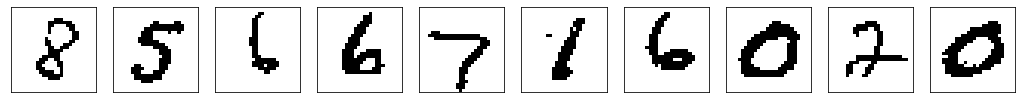

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-dfb678f3a050>", line 21, in <module>
    optimizer.step()
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/optimizer.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py", line 144, in step
    eps=group['eps'])
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/_functional.py", line 98, in adam
    param.addcdiv_(exp_avg, denom, value=-step_size)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py

KeyboardInterrupt: ignored

In [ ]:
from IPython import display


step = 0
while(True):
    for batch_index, batch in enumerate(train_loader):
        # x : image (B, 1, 28, 28,)
        # t : class (B)
        x, t = batch
        
        x = x.cuda()
        x[x >= 0.5] = 1.
        x[x < 0.5] = 0.

        # Backpropagation이 되도록 준비합니다.       
        model.train()    
        model.zero_grad()
        y = model(x)
        loss = nn.BCEWithLogitsLoss()(y, x)
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(step, loss.item())
        
        if step % 1000 == 0:
            display.clear_output()
            
            samples = torch.zeros(10, 1, 28, 28).cuda()
            model.eval()
            with torch.no_grad():
                samples = model.inference(x)
            _samples = samples.data.cpu().numpy()
            
            plt.figure(figsize=[18, 3])
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(_samples[i, 0], cmap='Greys')
                plt.xticks([])
                plt.yticks([])
            plt.show()
        
        step += 1